In [1]:
import numpy as np
import h5py 
import os
# plotting
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,
    'axes.labelsize': 30,
    'axes.titlesize': 30,
    'font.size': 30,
    'legend.fontsize': 10,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'text.usetex': True,
    'font.family': 'serif',
}
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update(params)
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
def equalize(ax):
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))

In [3]:
colors = [
    '#377eb8', '#ff7f00', '#4daf4a', 
    '#f781bf', '#a65628', '#984ea3', 
    '#999999', '#e41a1c', '#dede00',
    '#595959', '#5F9ED1', '#C85200',
    '#A2C8EC', '#FFBC79', '#000000'
]

In [4]:
base = 'results/exp3'
Ls = np.array([0.25, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])
sparsities = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
files = {}
for sparsity in sparsities:
    files[sparsity] = h5py.File(os.path.join(base, 'uoicorr%0.1f.h5' %sparsity), 'r')
    
n_features = 50

In [7]:
def L_to_idx(L):
    idx = np.argwhere(Ls == L).ravel()[0]
    return idx

# ROC

In [5]:
def plot_roc(sparsity, Ls, scaled=False, ax=None, showlegend=False):
    # extract files
    file = files[sparsity]
    fps = file['fp'][:]
    fns = file['fn'][:]
    # max fp/fn for scaling
    max_fp = int(n_features * (1 - sparsity))
    max_fn = int(n_features * sparsity)
    # set up figure
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for idx, L in enumerate(Ls):
        fp_mean = np.mean(fps[:, idx, :], axis=0)
        fn_mean = np.mean(fns[:, idx, :], axis=0)
        if scaled:
            fp_mean /= max_fp
            fn_mean /= max_fn
        ax.plot(fp_mean, fn_mean, color=colors[idx], linewidth=3, marker='o', markersize=10, label=r'$L=%0.1f$' %L)
    if showlegend:
        lgd = ax.legend(
            loc='center right', 
            bbox_to_anchor=(1.3, 0.5),
            prop={'size' : 20}
        )
        lgd.get_frame().set_edgecolor('black')
    return ax

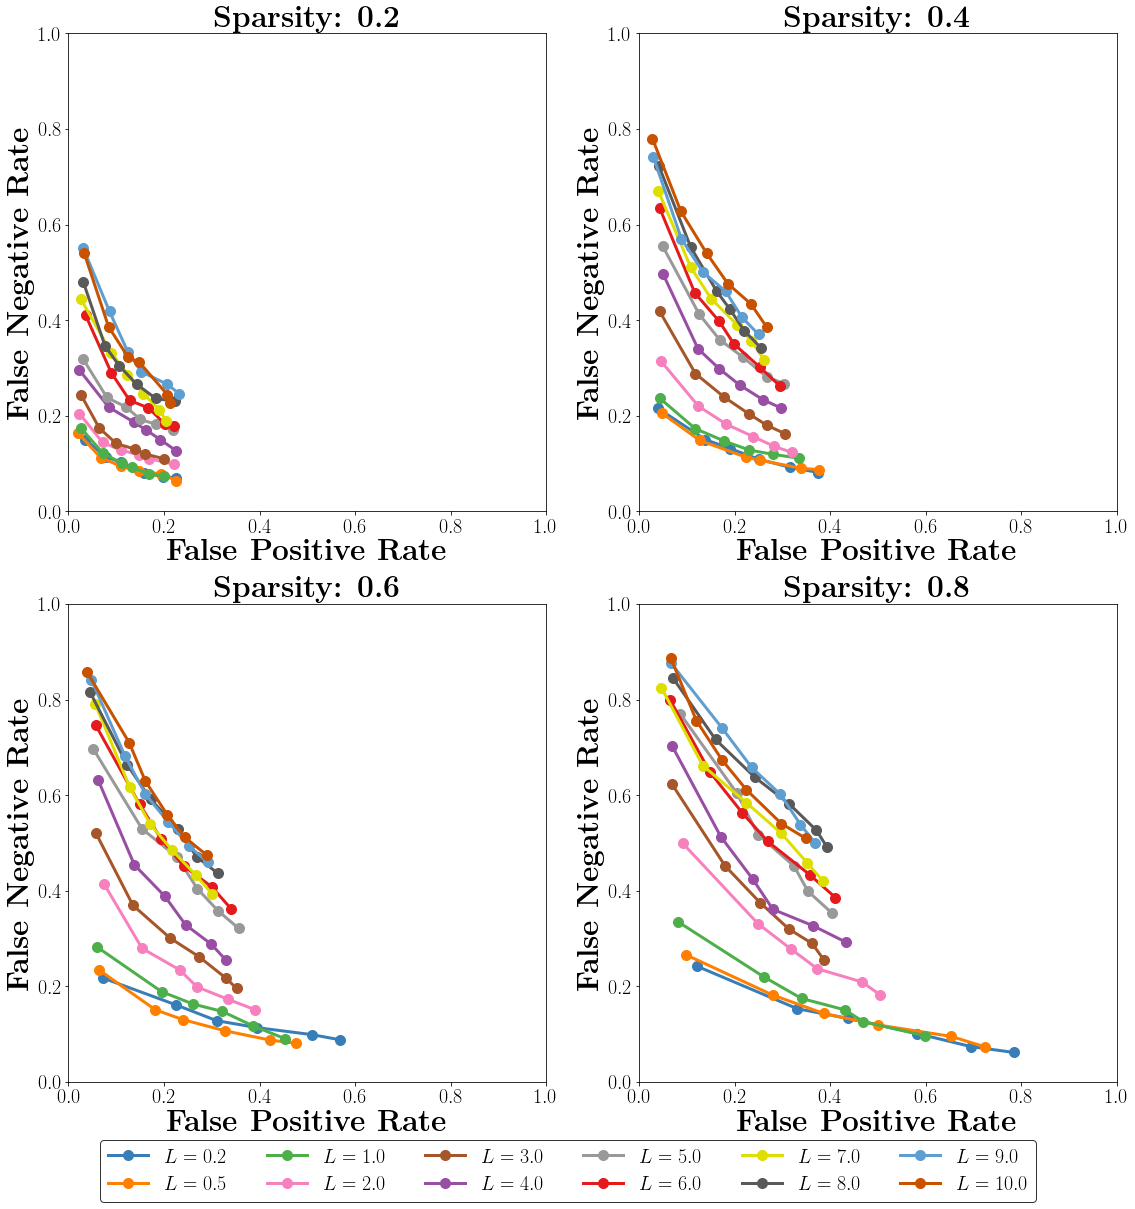

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
plot_roc(0.2, Ls=Ls, scaled=True, ax=axes[0,0])
axes[0,0].set_title(r'\textbf{Sparsity: 0.2}')
plot_roc(0.4, Ls=Ls, scaled=True, ax=axes[0,1])
axes[0,1].set_title(r'\textbf{Sparsity: 0.4}')
plot_roc(0.6, Ls=Ls, scaled=True, ax=axes[1,0])
axes[1,0].set_title(r'\textbf{Sparsity: 0.6}')
plot_roc(0.8, Ls=Ls, scaled=True, ax=axes[1,1])
axes[1,1].set_title(r'\textbf{Sparsity: 0.8}')
ax_list = axes.ravel()
for ax in ax_list:
    ax.set_xlim([0., 1.0])
    ax.set_ylim([0., 1.0])
    ax.set_xlabel(r'\textbf{False Positive Rate}')
    ax.set_ylabel(r'\textbf{False Negative Rate}')
    equalize(ax)
handles, labels = axes[1,1].get_legend_handles_labels()
lgd = fig.legend(
    handles, 
    labels, 
    loc='center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=6,
    prop={'size' : 20},
    bbox_transform=fig.transFigure
)
lgd.get_frame().set_edgecolor('black')
plt.tight_layout()
plt.savefig('exp3_roc.pdf', bbox_inches='tight')

# Magnitude of False Negatives

In [17]:
def calculate_mag_fn(sparsity, Ls, scaled=False):
    # extract files
    file = files[sparsity]
    # extract true and estimated parameters
    beta_trues = file['beta']
    beta_hats = file['beta_hats']
    # number of datasets
    n_datasets = beta_trues.shape[0]
    # enumerate over datasets and Ls
    mag_fn = np.zeros((n_datasets, Ls.size, selection_thresholds.size))
    for dataset in range(n_datasets):
        beta_true = beta_trues[dataset]
        for L_idx, L in enumerate(Ls):
            for sel_idx, sel_thres in enumerate(selection_thresholds):
                beta_hat_z = beta_hats[dataset, L_to_idx(L), sel_idx, :] == 0
                beta_true_tnfn = beta_true[beta_hat_z]
                n_fn = np.count_nonzero(beta_true_tnfn != 0)
                if scaled:
                    avg_fn = np.sum(beta_true_tnfn)/(np.sum(beta_true))
                else:
                    if n_fn == 0:
                        avg_fn = 0
                    else:
                        avg_fn = np.sum(beta_true_tnfn)/n_fn
                mag_fn[dataset, L_idx, sel_idx] = avg_fn
    return mag_fn

def plot_mag_fn(sparsity, Ls, ax=None, showlegend=False, scaled=False):
    mag_per_group = calculate_mag_fn(sparsity, Ls, scaled=scaled)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    spread = np.linspace(-0.4, 0.4, Ls.size)
    base_positions = 1.1 * np.arange(selection_thresholds.size)
    for L_idx, L in enumerate(Ls):
        ax.boxplot(
            [mag_per_group[mag_per_group[:, L_idx, sel_idx].ravel() != 0, L_idx, sel_idx] for sel_idx in range(selection_thresholds.size)],
            positions=base_positions + spread[L_idx],
            widths=0.15,
            boxprops={'facecolor' : colors[L_idx], 'linewidth' : 1.5},
            medianprops={'linewidth' : 1.5, 'color' : 'black', 'linestyle' : '--'},
            flierprops={'marker' : '.', 'markersize' : 12},
            whiskerprops={'linewidth' : 1.5},
            capprops={'linewidth' : 1.5},
            patch_artist=True,
            meanprops={'markerfacecolor' : 'black', 'markeredgecolor' : 'black'},
            showmeans=True,
            notch=True
        )
        # hack to get a label to show up
        ax.plot(0, 0, label=r'$L=%s$' %L, color=colors[L_idx], linewidth=5)
    ax.set_xticks(base_positions)
    ax.set_xticklabels(selection_thresholds)
    ax.set_xlim(base_positions[0] + spread[0] - 0.15, base_positions[-1] + spread[-1] + 0.15)
    if scaled:
        ax.set_ylim([0, 1])
    else:
        ax.set_ylim([0, 10])
    #ax.set_xlabel(r'\textbf{Lower Selection Threshold}')
    if scaled:
        ax.set_ylabel(r'\textbf{Scaled False Negative Rate}', fontsize=25)
    else:
        ax.set_ylabel(r'\textbf{Avg. Magnitude of FN}', fontsize=25)
    if showlegend:
        lgd = ax.legend(
            loc='center right', 
            bbox_to_anchor=(1.20, 0.5),
            prop={'size' : 28}
        )
        lgd.get_frame().set_edgecolor('black')
    ax.set_title(r'\textbf{Sparsity: %0.1f}' %sparsity, fontsize=35)

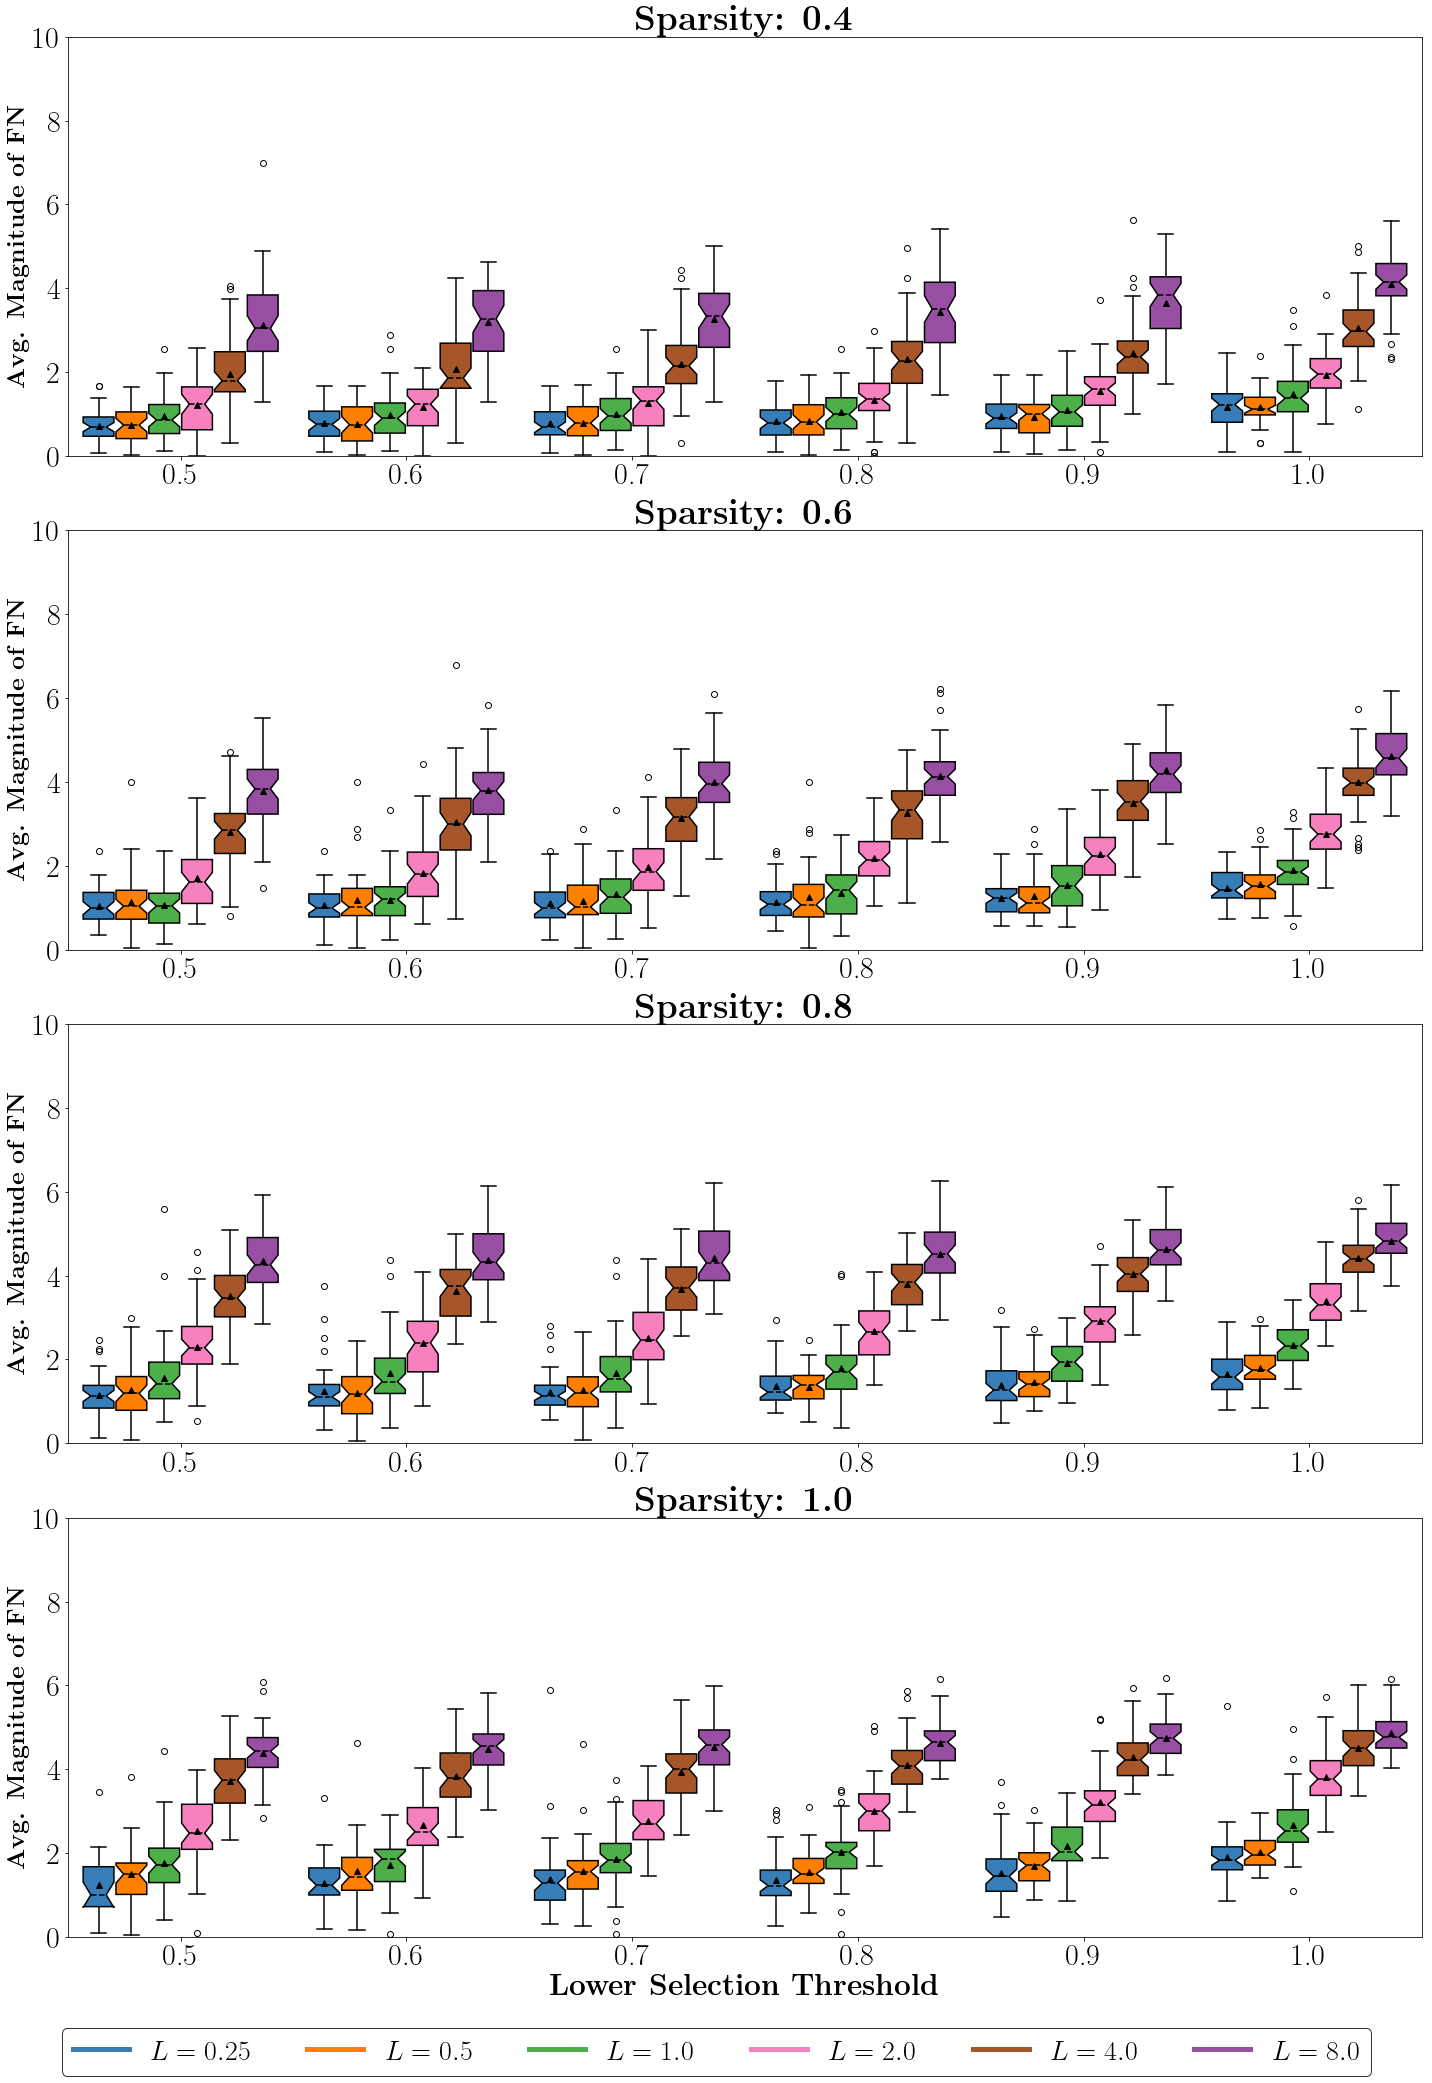

In [22]:
fig, axes = plt.subplots(4, 1, figsize=(20, 28))
plot_mag_fn(sparsity=0.4, Ls=np.array([0.25, 0.50, 1, 2, 4, 8]), ax=axes[0], scaled=False)
plot_mag_fn(sparsity=0.6, Ls=np.array([0.25, 0.50, 1, 2, 4, 8]), ax=axes[1], scaled=False)
plot_mag_fn(sparsity=0.8, Ls=np.array([0.25, 0.50, 1, 2, 4, 8]), ax=axes[2], scaled=False)
plot_mag_fn(sparsity=1.0, Ls=np.array([0.25, 0.50, 1, 2, 4, 8]), ax=axes[3], scaled=False)
axes[3].set_xlabel(r'\textbf{Lower Selection Threshold}')
for ax in axes:
    ax.tick_params(labelsize=30)
handles, labels = axes[3].get_legend_handles_labels()
lgd = fig.legend(
    handles, 
    labels, 
    loc='center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=6,
    prop={'size' : 28},
    bbox_transform=fig.transFigure
)
lgd.get_frame().set_edgecolor('black')
plt.tight_layout()
plt.savefig('exp3_mag_fn.pdf', bbox_inches='tight')

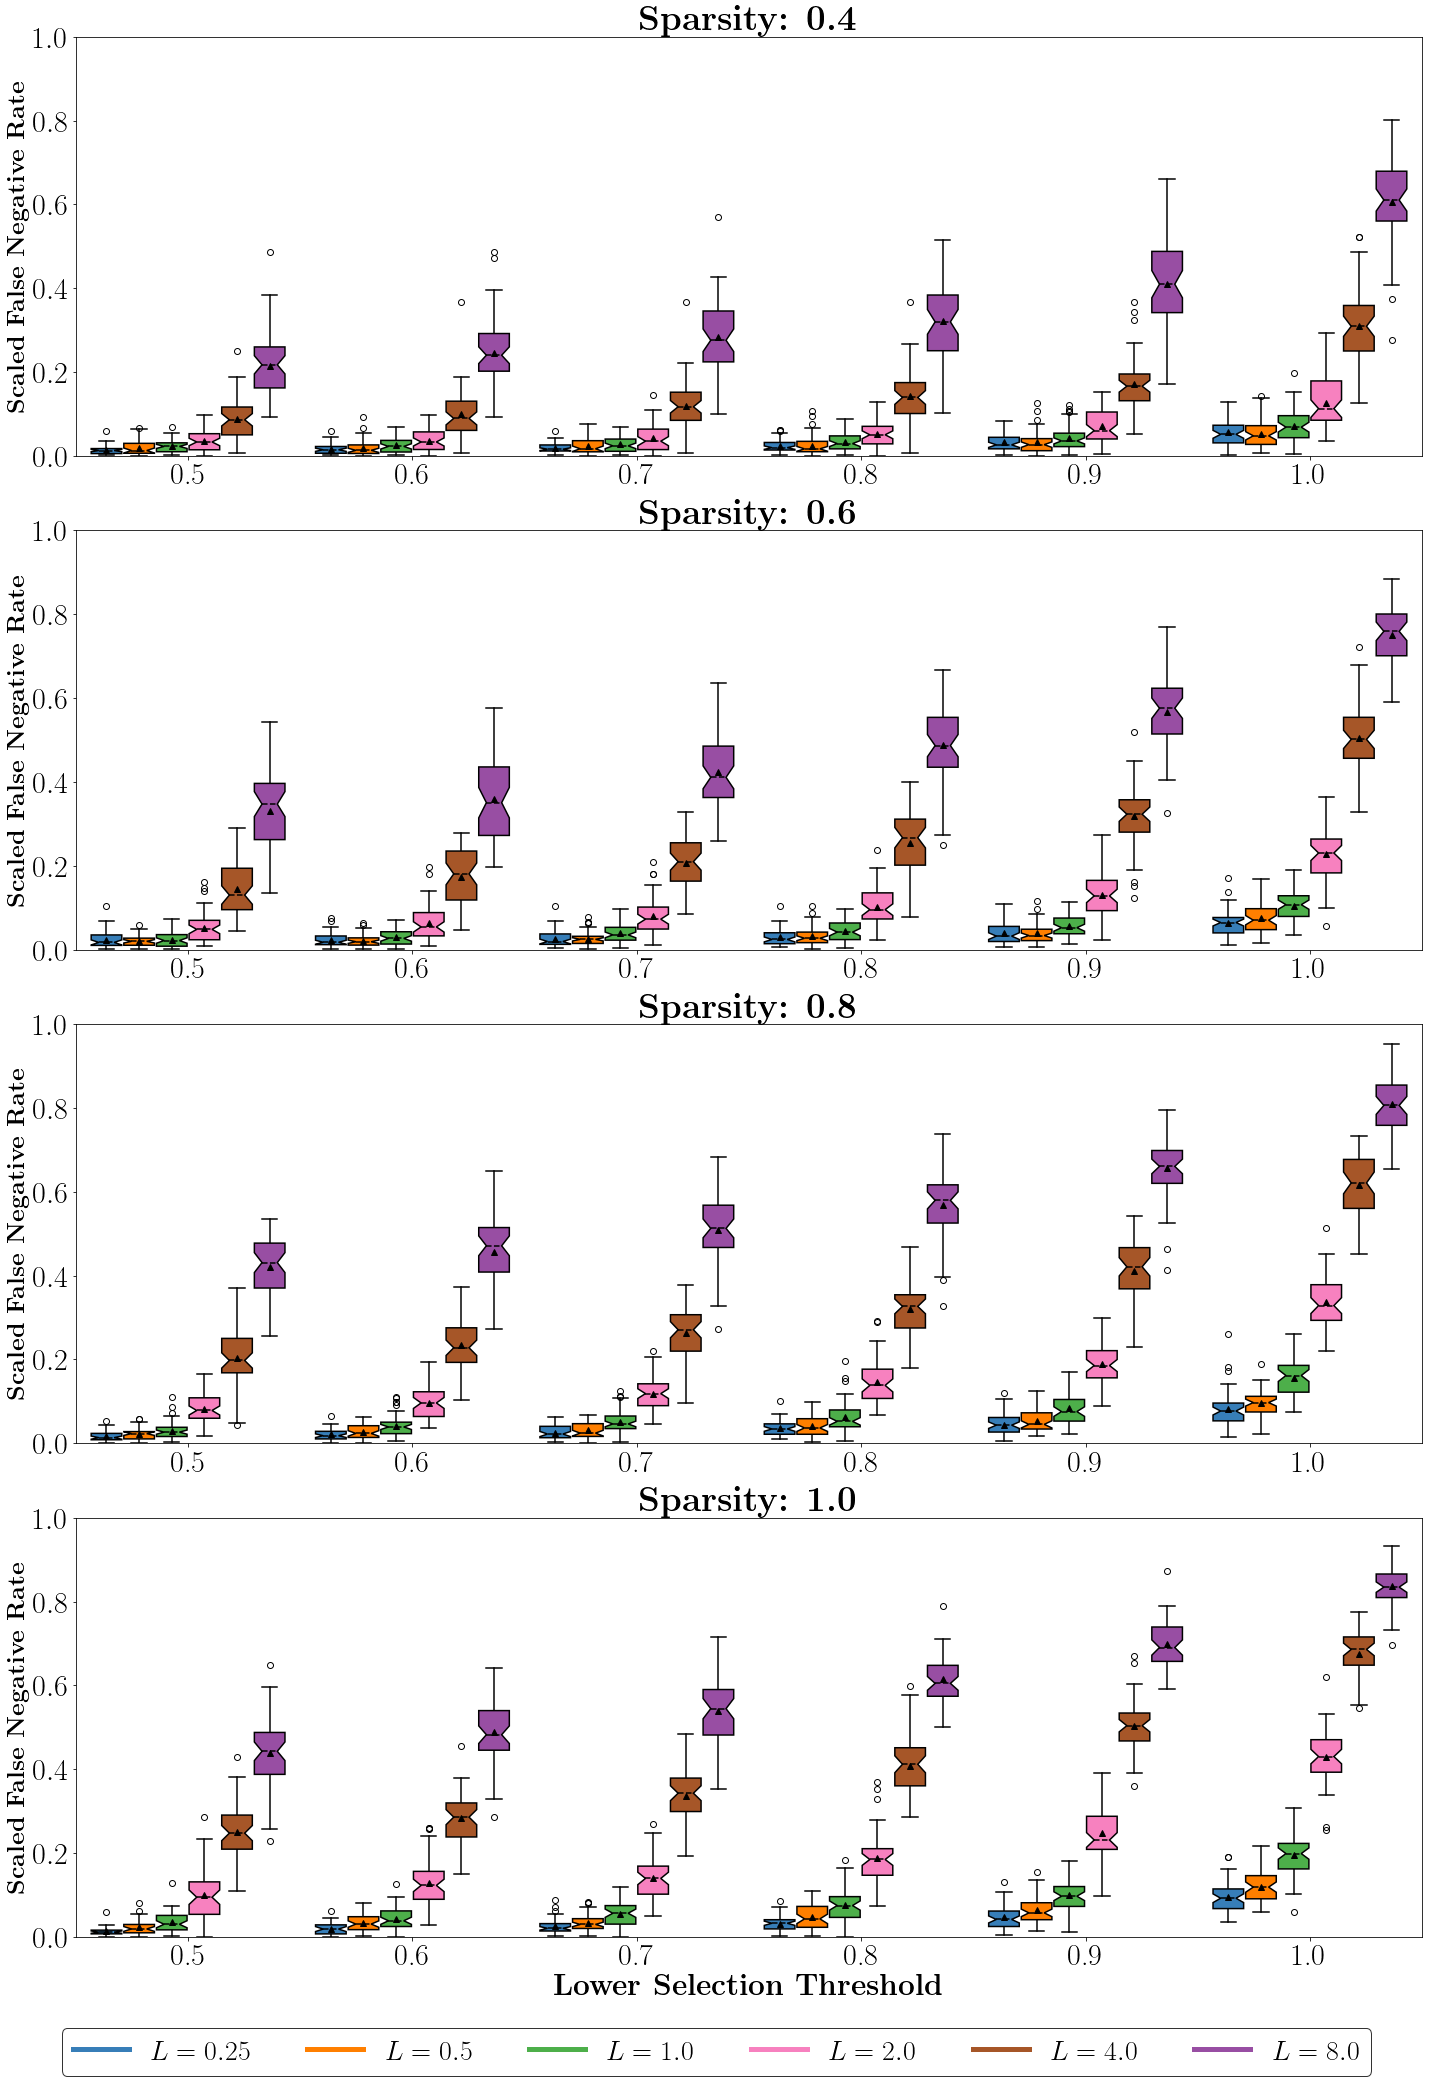

In [21]:
# scaled
fig, axes = plt.subplots(4, 1, figsize=(20, 28))
plot_mag_fn(sparsity=0.4, Ls=np.array([0.25, 0.50, 1, 2, 4, 8]), ax=axes[0], scaled=True)
plot_mag_fn(sparsity=0.6, Ls=np.array([0.25, 0.50, 1, 2, 4, 8]), ax=axes[1], scaled=True)
plot_mag_fn(sparsity=0.8, Ls=np.array([0.25, 0.50, 1, 2, 4, 8]), ax=axes[2], scaled=True)
plot_mag_fn(sparsity=1.0, Ls=np.array([0.25, 0.50, 1, 2, 4, 8]), ax=axes[3], scaled=True)
axes[3].set_xlabel(r'\textbf{Lower Selection Threshold}')
for ax in axes:
    ax.tick_params(labelsize=30)
handles, labels = axes[3].get_legend_handles_labels()
lgd = fig.legend(
    handles, 
    labels, 
    loc='center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=6,
    prop={'size' : 28},
    bbox_transform=fig.transFigure
)
lgd.get_frame().set_edgecolor('black')
plt.tight_layout()
plt.savefig('exp3_mag_fn_scaled.pdf', bbox_inches='tight')

# Selection Accuracy

In [26]:
def selection_accuracy(true, hats):
    true_idx = np.argwhere(true).ravel()
    hats_idx = np.argwhere(hats).ravel()
    sym_set_diff = np.union1d(
        np.setdiff1d(true_idx, hats_idx),
        np.setdiff1d(hats_idx, true_idx)
    )
    set_overlap = sym_set_diff.size/(true_idx.size + hats_idx.size)
    return 1 - set_overlap

def sel_acc(sparsity, Ls):
    # extract files
    file = files[sparsity]
    # extract true and estimated parameters
    beta_trues = file['beta']
    beta_hats = file['beta_hats']
    # number of datasets
    n_datasets = beta_trues.shape[0]
    # enumerate over datasets and Ls
    sel_acc_per_dataset = np.zeros((n_datasets, Ls.size, selection_thresholds.size))
    for dataset in range(n_datasets):
        beta_true = beta_trues[dataset]
        for L_idx, L in enumerate(Ls):
            for sel_idx, sel_thres in enumerate(selection_thresholds):
                beta_hat = beta_hats[dataset, L_to_idx(L), sel_idx, :] != 0
                sel_acc_per_dataset[dataset, L_idx, sel_idx] = selection_accuracy(beta_true, beta_hat)
    return sel_acc_per_dataset

def plot_sel_acc(sparsity, Ls, ax=None, showlegend=False):
    selacc = sel_acc(sparsity, Ls)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    spread = np.linspace(-0.4, 0.4, Ls.size)
    base_positions = 1.1 * np.arange(selection_thresholds.size)
    for L_idx, L in enumerate(Ls):
        ax.boxplot(
            [selacc[:, L_idx, sel_idx] for sel_idx in range(selection_thresholds.size)],
            positions=base_positions + spread[L_idx],
            widths=0.15,
            boxprops={'facecolor' : colors[L_idx], 'linewidth' : 1.5},
            medianprops={'linewidth' : 1.5, 'color' : 'black', 'linestyle' : '--'},
            flierprops={'marker' : '.', 'markersize' : 12},
            whiskerprops={'linewidth' : 1.5},
            capprops={'linewidth' : 1.5},
            patch_artist=True,
            meanprops={'markerfacecolor' : 'black', 'markeredgecolor' : 'black'},
            showmeans=True,
            notch=True
        )
        # hack to get a label to show up
        ax.plot(0, 0, label=r'$L=%s$' %L, color=colors[L_idx], linewidth=5)
    ax.set_xticks(base_positions)
    ax.set_xticklabels(selection_thresholds)
    ax.set_xlim(base_positions[0] + spread[0] - 0.15, base_positions[-1] + spread[-1] + 0.15)
    ax.set_ylim([0, 1])
    ax.tick_params(labelsize=30)
    ax.set_ylabel(r'\textbf{Selection Accuracy}', fontsize=25)
    if showlegend:
        lgd = ax.legend(
            loc='center right', 
            bbox_to_anchor=(1.18, 0.5),
            prop={'size' : 28}
        )
        lgd.get_frame().set_edgecolor('black')
    ax.set_title(r'\textbf{Sparsity: %0.1f}' %sparsity, fontsize=35)

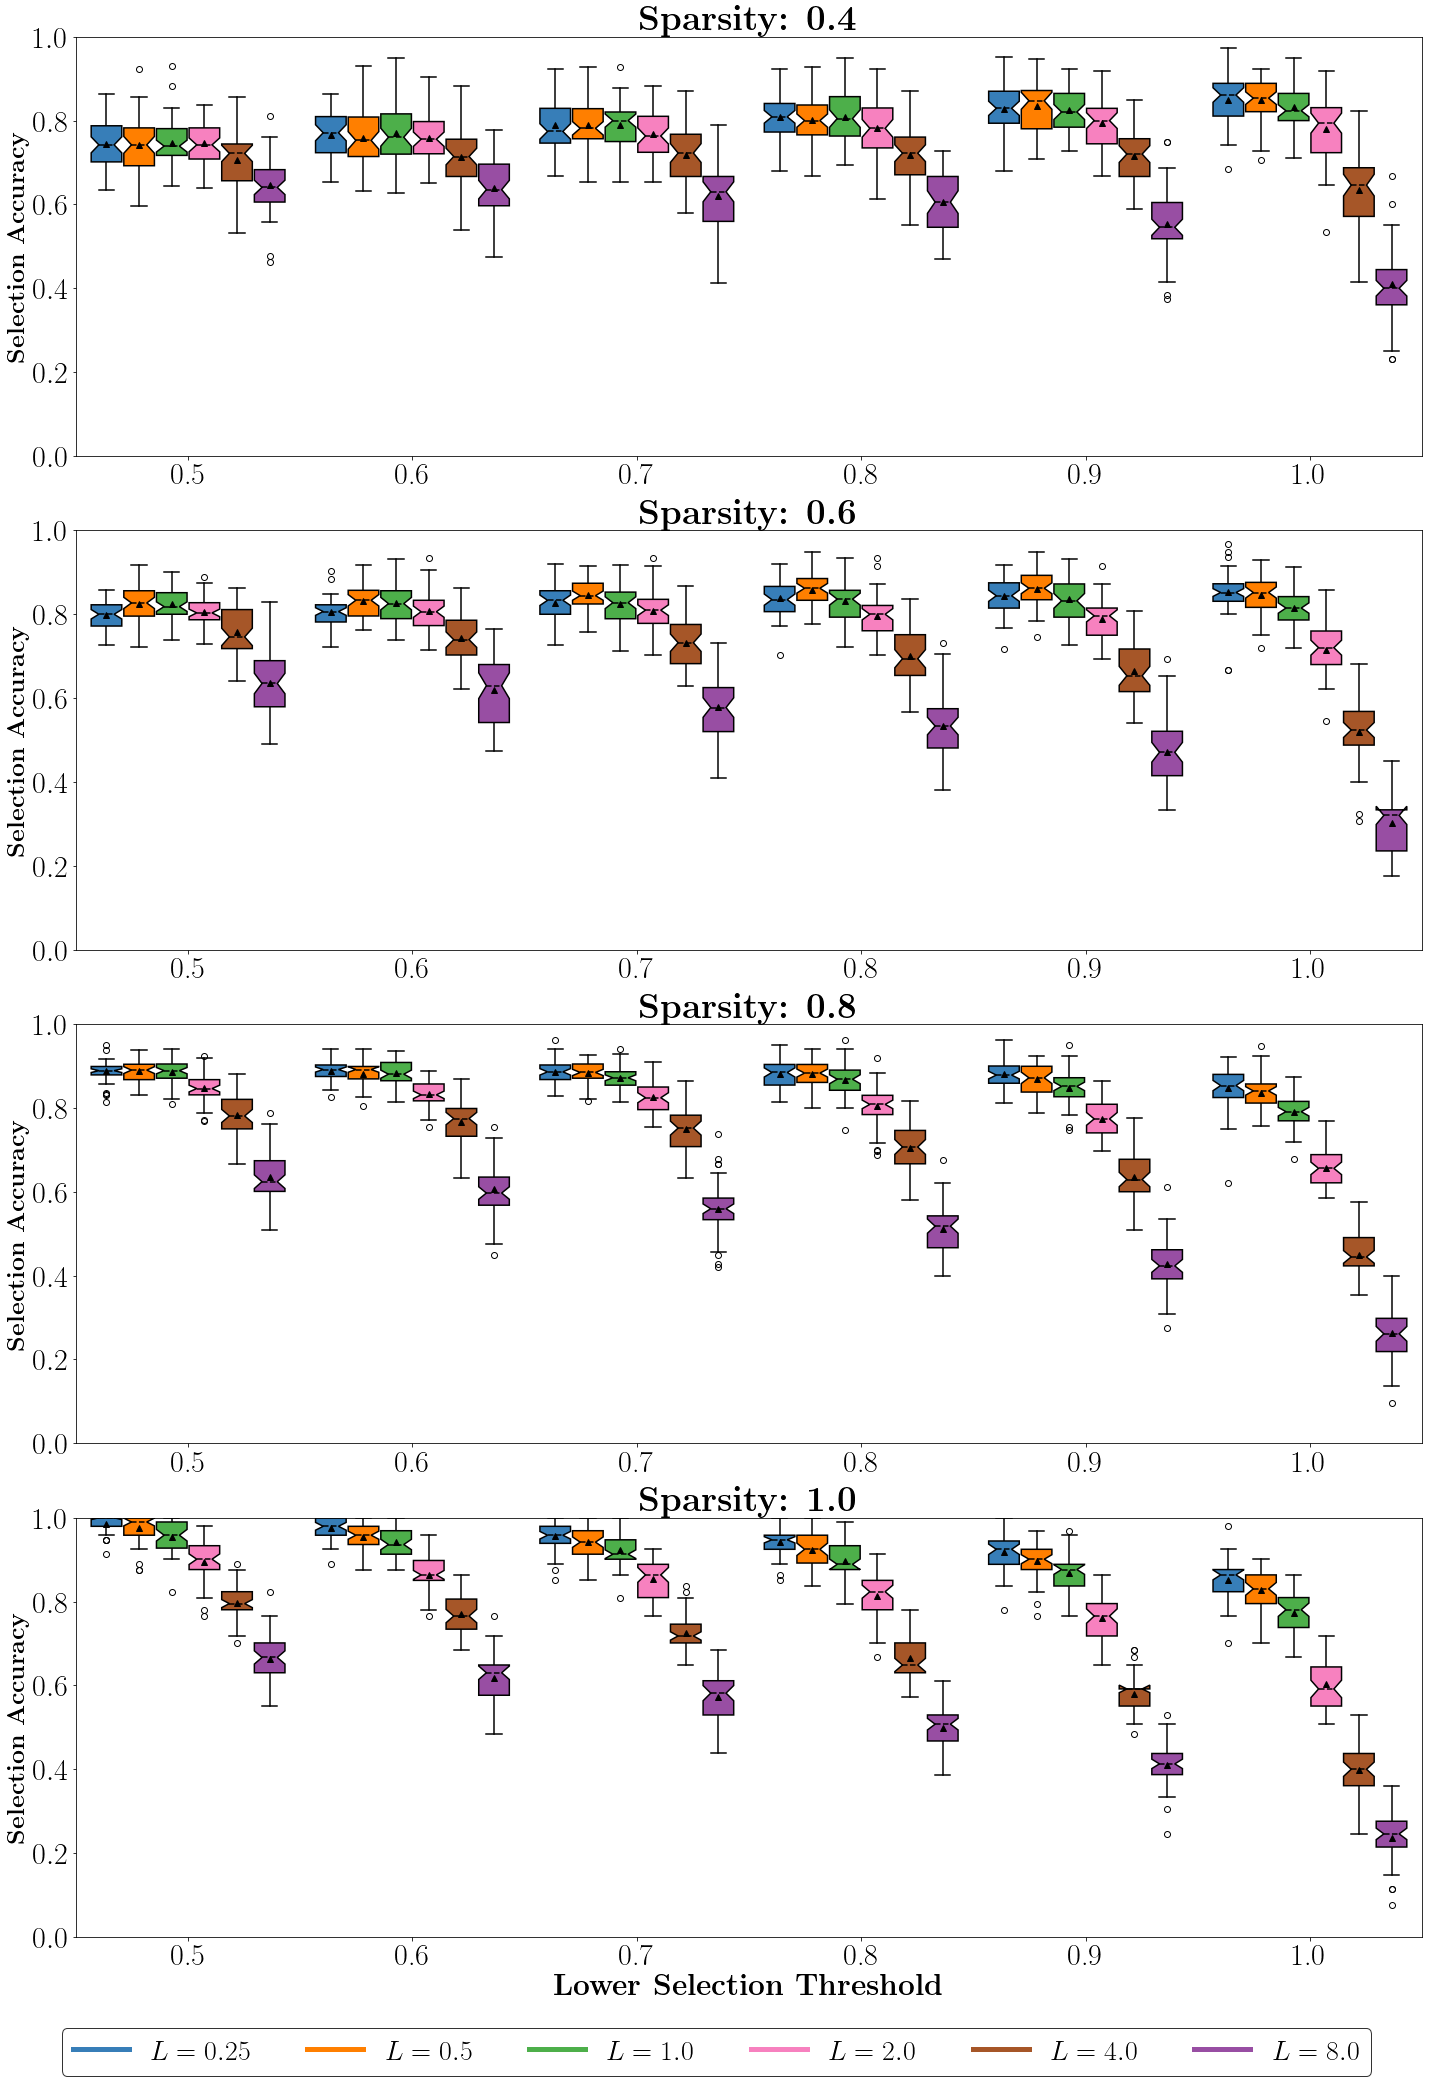

In [28]:
fig, axes = plt.subplots(4, 1, figsize=(20, 28))
plot_sel_acc(sparsity=0.4, Ls=np.array([0.25, 0.50, 1, 2, 4, 8]), ax=axes[0])
plot_sel_acc(sparsity=0.6, Ls=np.array([0.25, 0.50, 1, 2, 4, 8]), ax=axes[1])
plot_sel_acc(sparsity=0.8, Ls=np.array([0.25, 0.50, 1, 2, 4, 8]), ax=axes[2])
plot_sel_acc(sparsity=1.0, Ls=np.array([0.25, 0.50, 1, 2, 4, 8]), ax=axes[3])
axes[3].set_xlabel(r'\textbf{Lower Selection Threshold}')
for ax in axes:
    ax.tick_params(labelsize=30)
handles, labels = axes[3].get_legend_handles_labels()
lgd = fig.legend(
    handles, 
    labels, 
    loc='center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=6,
    prop={'size' : 28},
    bbox_transform=fig.transFigure
)
lgd.get_frame().set_edgecolor('black')
plt.tight_layout()
plt.savefig('exp3_sel_acc.pdf', bbox_inches='tight')